<a href="https://colab.research.google.com/drive/1Hx3VYb6ma0F8VtktllV07CgPl5WJ_6vl?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install the required packages

In [ ]:
!pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Import required packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm,uniform
import time
import corner
import scipy.optimize as op
# from numpy import *

#Load Hubble parameter measurements dataset

In [ ]:
x,y,yerr = np.loadtxt('https://raw.githubusercontent.com/darshanbeniwal/Astro_data_analysis_w_Python_GHRCE_IUCCA_2023/main/DataFiles/H_30.txt', unpack=True)

#Metropolis-Hastings Algorithm

###Model: $\Rightarrow~~~H(z)=H_0\sqrt{\Omega_{m0}(1+z)^3+\Omega_{\Lambda0}+(1-\Omega_{m0}-\Omega_{\Lambda0})(1+z)^2)}$

##Define initial points of parameters

In [ ]:
#Initial seeds
h0_ini,om_ini,ol_ini=60,0.2,0.6

##Define likelihood function

In [ ]:
#Define log-Likelihood Function
def likelihood(theta, x, y, yerr):  
    h0, om,ol= theta
    model = h0* (((om*(1.0+x)**3)+ol+(1-om-ol)*(1+x)**2)**0.5)
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(6.28*inv_sigma2)))


##Define Prior Function

In [ ]:
#Define Prior Function
def prior(theta):
    h0, om, ol= theta
    if 50.0< h0 < 100.0 and 0.0 < om < 1.0 and 0.0 < ol < 1.2: 
        return 0.0
    return -np.inf

##Define Posterior Function

In [ ]:
#Degine Posterior Function
def posterior(theta, x, y, yerr):
    lp = prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp + likelihood(theta, x, y, yerr))


##Define steps and burn-in phase

In [ ]:
#Define number of parameter, steps, burn-in phase
ndim=3
nsteps=300000
nburn_in=1000

##Run Metropolis_Hasting Algorithm

In [ ]:
initials=h0_ini,om_ini,ol_ini

In [ ]:
start_time = time.time()


#Define Metropolis-Hastings Function
def Metropolis_Hastings(parameter_init, iteration_time):
    result = []
    result.append(parameter_init)
    for t in range(iteration_time):
        step_var = [1, 0.01,0.05]
        proposal = np.zeros(3)
        for i in range(3):
            proposal[i] = norm.rvs(loc=result[-1][i], scale=step_var[i])
            probability = np.exp(posterior(proposal,x,y,yerr) - posterior(result[-1],x,y,yerr))
            if (uniform.rvs() < probability):
                result.append(proposal)
            else:
                result.append(result[-1]) 
    return (result)

result = Metropolis_Hastings(initials, nsteps)

result = result[nburn_in:]
samples_MH=np.array(result)
h0_mcmc, om_mcmc,ol_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples_MH,
                       [16, 50, 84],axis=0)))

print("----------------------------------------------------------------------\n")
print("Execution time with steps=%s------> %6.3f seconds" % 
      (nsteps,(time.time() - start_time)))
print("----------------------------------------------------------------------\n")

----------------------------------------------------------------------

Execution time with steps=300000------> 263.614 seconds
----------------------------------------------------------------------



##Draw Traceplots/Chains

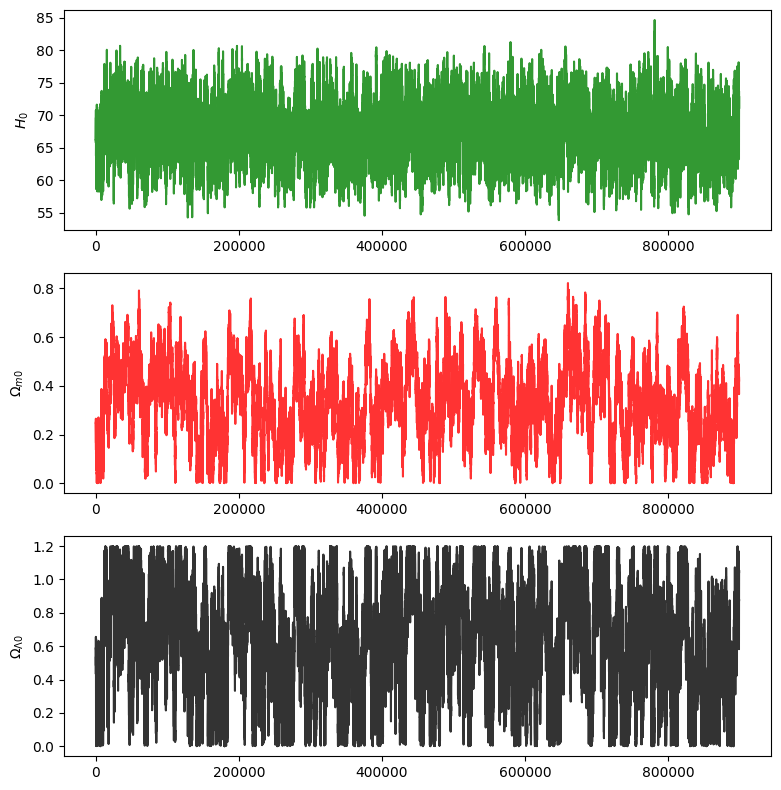

In [ ]:
# Plot the traceplots of the MCMC chains
fig, axes = plt.subplots(3, 1, figsize=(8, 8))
samples = samples_MH.T

# Plot the traceplot of H0
axes[0].plot(samples[0], "g", alpha=0.8)
axes[0].set_ylabel("$H_0$")

# Plot the traceplot of Om
axes[1].plot(samples[1], "r", alpha=0.8)
axes[1].set_ylabel("$\Omega_{m0}$")

# Plot the traceplot of Ol
axes[2].plot(samples[2], "k", alpha=0.8)
axes[2].set_ylabel("$\Omega_{\Lambda 0}$")

plt.tight_layout()
# plt.savefig("FLCDM_H_31_MH_traces.png")
plt.show()


##Print final results

In [ ]:
print("""MCMC result:
    H0 = {0[0]} +{0[1]} -{0[2]}
    Om = {2[0]} +{2[1]} -{2[2]}
    Ol = {4[0]} +{4[1]} -{4[2]}
""".format(h0_mcmc, h0_ini, om_mcmc, om_ini, ol_mcmc, ol_ini))

MCMC result:
    H0 = 67.42655426648537 +4.248513948585796 -4.1960703485647315
    Om = 0.3269338794947502 +0.1758962766911612 -0.1716755641828829
    Ol = 0.6576503707130374 +0.3360935730942902 -0.36858638566290236



##Plot Contours

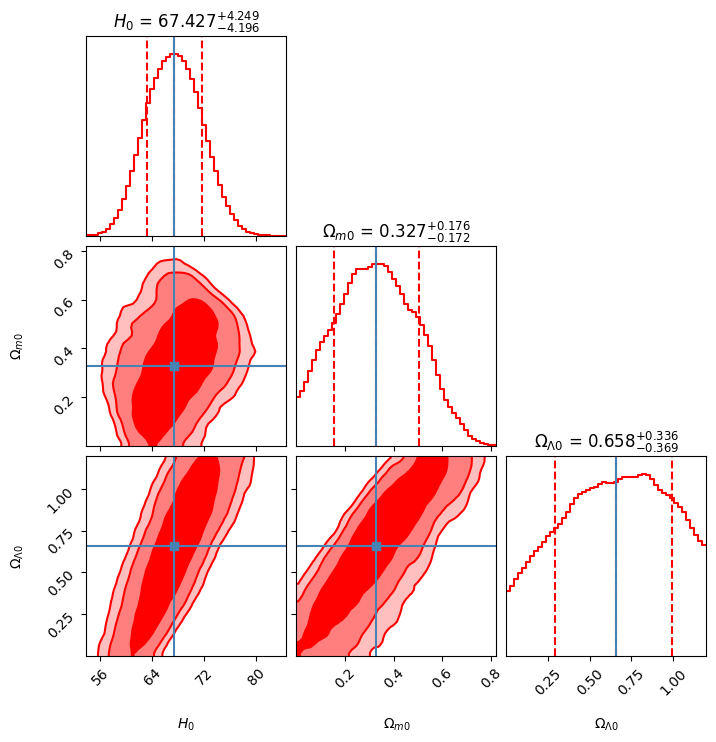

In [ ]:
fig = corner.corner(samples_MH,bins=50,color="red",labels=["$H_0$","$\Omega_{m0}$","$\Omega_{\Lambda0}$"],
                    truths=[h0_mcmc[0],om_mcmc[0],ol_mcmc[0]],fill_contours=True,
                    levels=(0.68,0.95,0.99,),
                    quantiles=[0.16, 0.5, 0.84],title_fmt='.3f',plot_datapoints=False,smooth=True, 
                    smooth1d=True,show_titles=True)

##Save Contour Plot

In [ ]:
fig.savefig("Non-FLCDM_H_30_MH.png",dpi=400)